In [ ]:
import pandas as pd, numpy as np, os, gc
from glob import glob
import holidays
from dateutil.relativedelta import relativedelta
import plotly.express as px, seaborn as sns, matplotlib.pyplot as plt
# sns.set()
plt.style.use("default")
pd.set_option('display.max_columns', 500)

In [ ]:
x=['day_'+i.lower()[:3] for i in 'Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday'.split(', ')]
days={i:j for i,j in enumerate(x)}
days

{0: 'day_mon',
 1: 'day_tue',
 2: 'day_wed',
 3: 'day_thu',
 4: 'day_fri',
 5: 'day_sat',
 6: 'day_sun'}

In [ ]:
# !pip install holidays

# Ozone data (but quite null sad)
https://data-airparif-asso.opendata.arcgis.com/search?collection=Dataset&q=o3
- For measurements at Tour Eiffel (3ème étage)

In [ ]:
files = glob('data/*_O3.csv')
df_ozone = []
for file in files:
    temp = (pd.read_csv(file, usecols=['Unnamed: 0', 'EIFF3:O3'])
            .rename(columns={'Unnamed: 0': 'time', 'EIFF3:O3': 'o3'})
            .dropna(subset=['time']))
    temp['time'] = pd.to_datetime(temp.time).dt.tz_localize(None)
    temp = temp.set_index('time').astype(float)
    temp.columns = [i.strip() for i in temp.columns]
    df_ozone.append(temp.reset_index())

df_ozone = pd.concat(df_ozone, ignore_index=True)
df_ozone

,time,o3
0,2018-01-01 01:00:00,81.0
1,2018-01-01 02:00:00,82.0
2,2018-01-01 03:00:00,77.0
3,2018-01-01 04:00:00,76.0
4,2018-01-01 05:00:00,75.0
...,...,...
53011,2024-01-18 20:00:00,60.5
53012,2024-01-18 21:00:00,60.0
53013,2024-01-18 22:00:00,NaN
53014,2024-01-18 23:00:00,NaN


# Temperature data
https://meteo.data.gouv.fr/datasets/donnees-climatologiques-de-base-horaires/
- FF: wind force averaged over 10 minutes
- T: instantaneous sheltered temperature (in Â°C and 1/10)

In [ ]:
files=glob('data/H_*.csv.gz')
df_temp=[]
for file in files:
    temp=(pd.read_csv(file, sep=';', usecols=['FF',' T','NUM_POSTE','AAAAMMJJHH'])
          .query("NUM_POSTE==75107005") # TOUR EIFFEL
          .dropna(axis=1, how='all'))
    temp['time']=pd.to_datetime(temp.AAAAMMJJHH, format="%Y%m%d%H")
    temp=temp.set_index('time').drop(columns=['NUM_POSTE','AAAAMMJJHH']).astype(float)
    temp.columns=[i.strip() for i in temp.columns]
    temp=temp.rename(columns={'FF':'wind','T':'temp'}).reset_index()
    df_temp.append(temp)

df_temp=pd.concat(df_temp, ignore_index=True)
df_temp

,time,wind,temp
0,2010-01-01 00:00:00,8.0,-1.2
1,2010-01-01 01:00:00,9.0,-1.4
2,2010-01-01 02:00:00,8.0,-1.7
3,2010-01-01 03:00:00,8.0,-2.0
4,2010-01-01 04:00:00,8.0,-2.2
...,...,...,...
117753,2022-12-31 19:00:00,18.1,13.9
117754,2022-12-31 20:00:00,18.2,14.0
117755,2022-12-31 21:00:00,18.7,14.3
117756,2022-12-31 22:00:00,16.7,14.2


# Read NO2 data + Add time variables
https://data-airparif-asso.opendata.arcgis.com/search?collection=Dataset&q=pa07

In [ ]:
# Raed all files
files = glob('data/*_PA07.csv')
df_all = []
for file in files:
    x = pd.read_csv(file)
    x.columns = [i.lower() for i in x.iloc[3, :].replace(
        {np.nan: 'TIME', 3: 'OBJECTID'}).to_list()]
    df_all.append(x[x.objectid > 4])
df_all = pd.concat(df_all, ignore_index=True)

# CLean up data types
df_all['time'] = pd.to_datetime(df_all['time']).dt.tz_localize(None)
cols_no = [i for i in df_all.columns if i.startswith('no')]
df_all[cols_no] = df_all[cols_no].astype(float)

# Add additional time variables
df_all['year'] = df_all['time'].dt.year
df_all['month'] = df_all['time'].dt.month
df_all['day'] = df_all['time'].dt.day
df_all['hour'] = df_all['time'].dt.hour
df_all['weekday'] = df_all.time.dt.weekday
df_all['weekofyear'] = df_all.time.dt.weekofyear

# Drop duplicates
df_all = df_all.drop_duplicates(
    subset=['time'], keep='last').reset_index(drop=True)

# Sort values
df_all.sort_values(by='time', inplace=True)

# #Drop 2024
# df_all=df_all[df_all.year<2024]

# Add dummy variables for time
df_all = pd.concat([df_all,
                    pd.get_dummies(df_all.time.dt.month_name().str.lower().str[:3].apply(lambda x: 'month_'+x)),
                    pd.get_dummies(df_all['weekday'].map(days)),
                    pd.get_dummies('week_'+df_all.weekofyear.astype(str)),
                    pd.get_dummies('day_'+df_all.day.astype(str)),
                    pd.get_dummies('hr_'+df_all.hour.astype(str))
                   ], axis=1)

df_all.drop(columns=['objectid','month', 'weekday', 'weekofyear',
            'day', 'hour'], inplace=True)

# combine with temperature data
df_all = pd.merge(df_temp, df_all, on='time', how='right')
df_all = pd.merge(df_ozone, df_all, on='time', how='right')
df_all

C:\Users\Adina Bondoc\AppData\Local\Temp\ipykernel_23248\3510695313.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_all['weekofyear'] = df_all.time.dt.weekofyear


,time,o3,wind,temp,no2,no,nox,year,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,week_1,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_2,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_3,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_4,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_5,week_50,week_51,week_52,week_53,week_6,week_7,week_8,week_9,day_1,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_2,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_3,day_30,day_31,day_4,day_5,day_6,day_7,day_8,day_9,hr_0,hr_1,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_2,hr_20,hr_21,hr_22,hr_23,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9
0,2018-01-02 01:00:00,77.0,16.9,6.2,NaN,NaN,NaN,2018,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-02 02:00:00,77.0,14.8,6.2,NaN,NaN,NaN,2018,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-02 03:00:00,74.0,16.0,6.3,NaN,NaN,NaN,2018,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2018-01-02 04:00:00,74.0,18.2,6.1,NaN,NaN,NaN,2018,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2018-01-02 05:00:00,73.0,15.3,6.2,NaN,NaN,NaN,2018,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52987,2024-01-18 20:00:00,60.5,8.5,-0.4,63.6,11.3,81.1,2024,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
52988,2024-01-18 21:00:00,60.0,7.6,-0.2,57.0,7.4,68.3,2024,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
52989,2024-01-18 22:00:00,NaN,7.3,0.0,NaN,NaN,NaN,2024,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
52990,2024-01-18 

In [ ]:
df_all.isna().sum()

time       0
o3      9441
wind    1641
temp    1233
no2     1541
        ... 
hr_5       0
hr_6       0
hr_7       0
hr_8       0
hr_9       0
Length: 135, dtype: int64

In [ ]:
# Check those will null values for all nitrates
df_all[df_all[['no2','no','nox']].isna().sum(axis=1)==3].year.value_counts()

2019    600
2020    472
2022    156
2021    120
2018    114
2023     60
2024      7
Name: year, dtype: int64

In [ ]:
df_all.year.value_counts()

2020    8784
2019    8760
2021    8760
2022    8760
2023    8760
2018    8735
2024     433
Name: year, dtype: int64

In [ ]:
# # Try holidays
# hdays=holidays.country_holidays('FR', language='en')
# hdays.get('2014-12-25')

# Add holidays
hdays=holidays.country_holidays(country='FR', years=range(df_all.year.min(), df_all.year.max()+1))
df_all['holiday']=df_all['time'].dt.date.map(hdays)

# clean up holidays
df_all['holiday']=df_all.holiday.str.replace(" ",'_').str.replace('\W', '_').str.lower()#.unique()

hdays=df_all.holiday.dropna().unique()
print(hdays)

# Change to binary variables
for i in hdays:
    print(i)
    df_all[f'hday_{i}']=np.where(df_all.holiday==i,1,0)

# binary - 1 if hliday, 0 if not
df_all['hday']=np.where(df_all.holiday.notna(),1,0)

# day before holiday and day after holiday
df_all['hday_after1']=df_all.time.apply(lambda x: x + relativedelta(days=1)).map(df_all.set_index('time').hday.to_dict()).fillna(0)
df_all['hday_before1']=df_all.time.apply(lambda x: x + relativedelta(days=-1)).map(df_all.set_index('time').hday.to_dict()).fillna(0)

# convert to integer for binary columns
cols=[i for i in df_all.columns if i.startswith('hday')]

df_all[cols]=df_all[cols].astype(int)

df_all.drop(columns=['holiday'], inplace=True)

C:\Users\Adina Bondoc\AppData\Local\Temp\ipykernel_23248\2863752056.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df_all['holiday']=df_all.holiday.str.replace(" ",'_').str.replace('\W', '_').str.lower()#.unique()


['lundi_de_pâques' 'fête_du_travail' 'fête_de_la_victoire' 'ascension'
 'lundi_de_pentecôte' 'fête_nationale' 'assomption' 'toussaint'
 'armistice' 'noël' 'jour_de_l_an']
lundi_de_pâques
fête_du_travail
fête_de_la_victoire
ascension
lundi_de_pentecôte
fête_nationale
assomption
toussaint
armistice
noël
jour_de_l_an


# Check nulls

2018


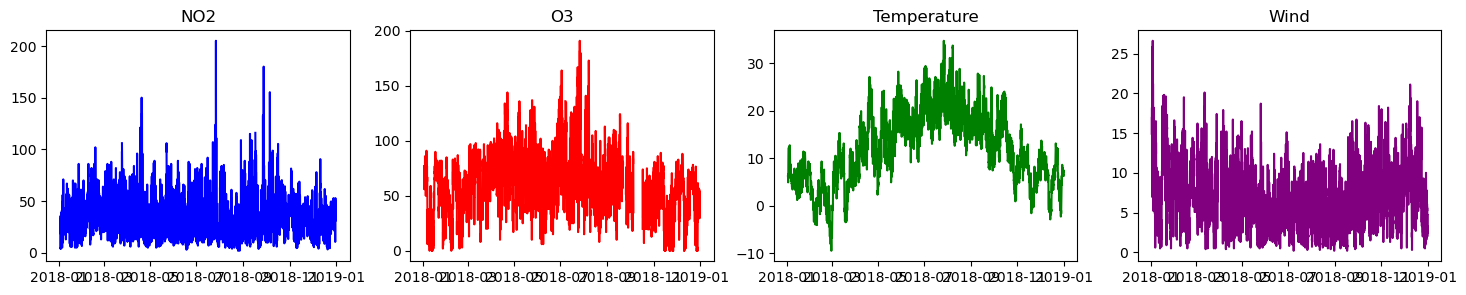

2019


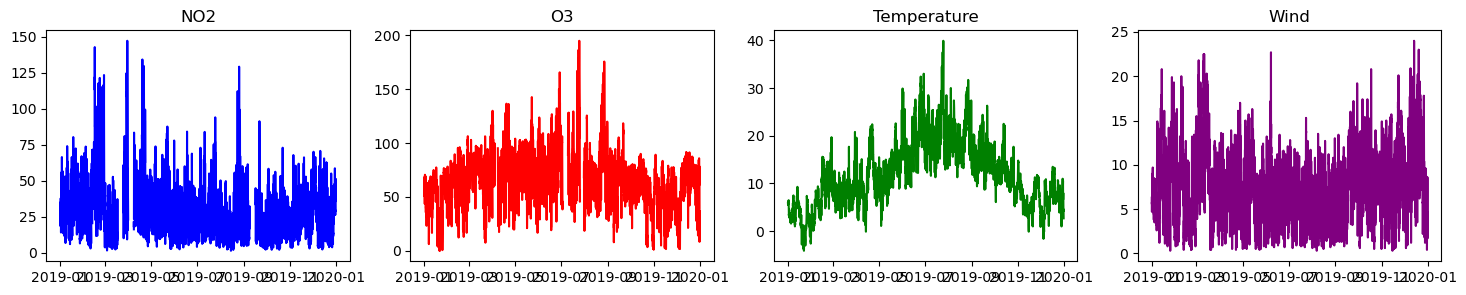

2020


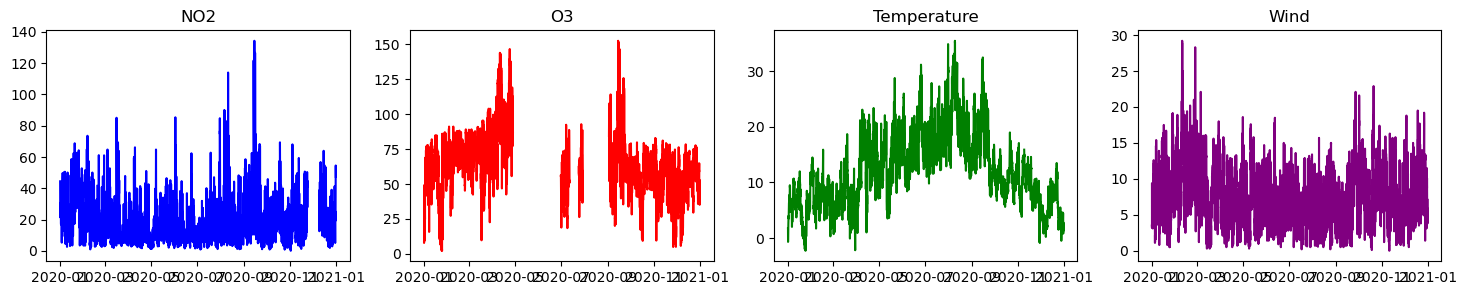

2021


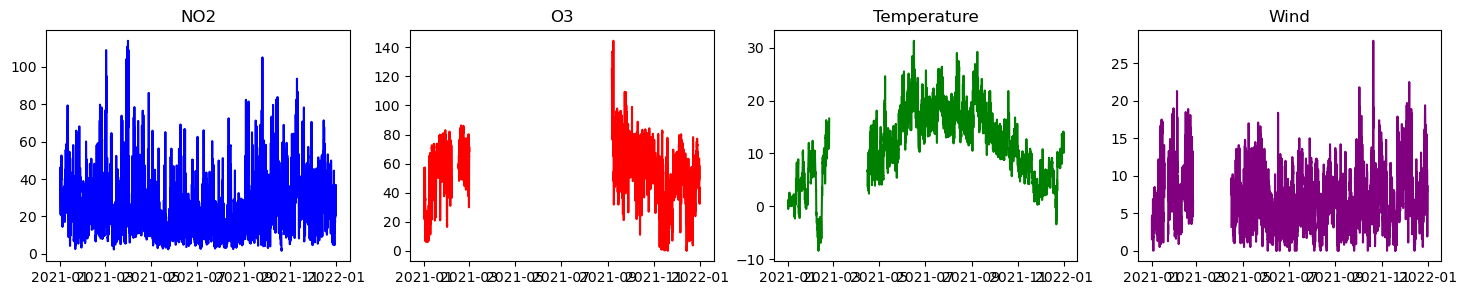

2022


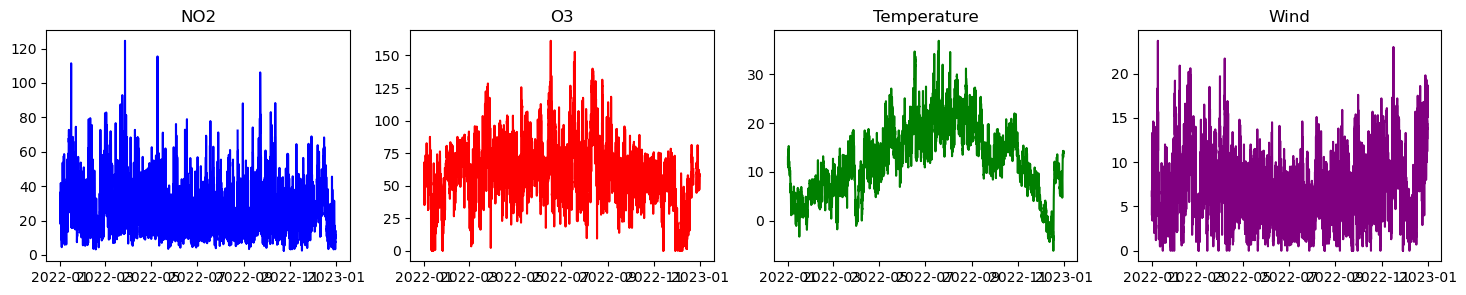

2023


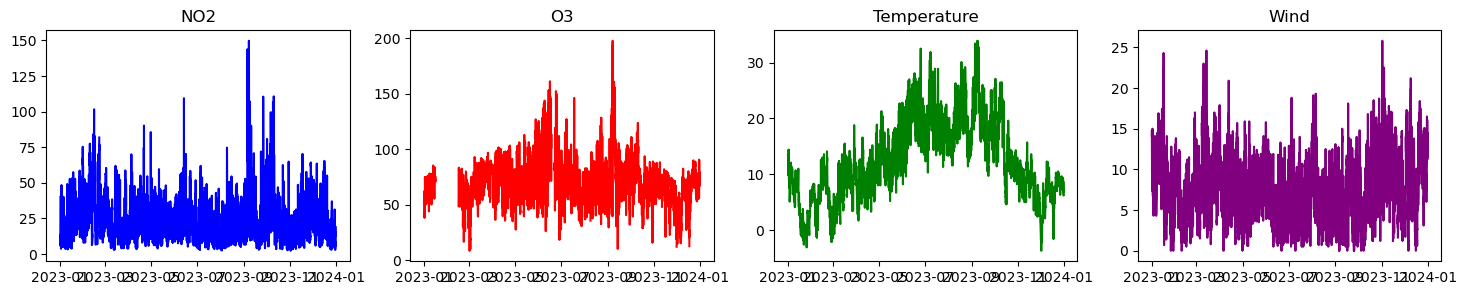

2024


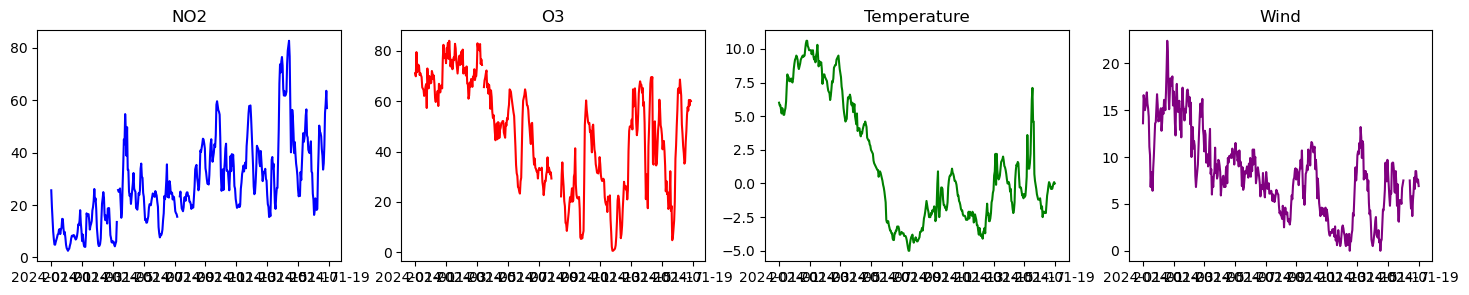

In [ ]:
# investigate per year

# px.line(df_all[(df_all.year.isin([2019]))
# #               &(df_all.month.isin([9,10]))
#               ], 'time','no2')

for y in df_all.year.unique():
    print(y)
    data=df_all[(df_all.year.isin([y]))]
    fig, ax =plt.subplots(1,4, figsize=(18,3))
#     sns.lineplot(data=data, x='time',y='no2', color='blue', ax=ax[0])
#     sns.lineplot(data=data, x='time',y='o3', color='red', ax=ax[1])
    ax[0].plot(data.time, data.no2, color='blue')
    ax[0].set_title('NO2')
    ax[1].plot(data.time, data.o3, color='red')
    ax[1].set_title('O3')
    ax[2].plot(data.time, data.temp, color='green')
    ax[2].set_title('Temperature')
    ax[3].plot(data.time, data.wind, color='purple')
    ax[3].set_title('Wind')

    plt.show()

In [ ]:
# Check null groups

for col in ['no2', 'o3', 'temp', 'wind']:
    print('='*30,col,'='*30)
    # Create dataframe
    na_groups = df_all[col].notna().cumsum()[df_all[col].isna()]
    lengths_consecutive_na = df_all.groupby(na_groups).time.agg([len,min,max])
    lengths_consecutive_na['missing']=lengths_consecutive_na['max']-lengths_consecutive_na['min']

    # Check distribution of lengthss
    display(lengths_consecutive_na.len.value_counts().head(),
          lengths_consecutive_na.sort_values(by='len', ascending=False).head())

============================== no2 ==============================


1    99
2    45
3    24
4     8
5     7
Name: len, dtype: int64

,len,min,max,missing
no2,,,,
24548.0,365,2020-11-24 11:00:00,2020-12-09 15:00:00,15 days 04:00:00
10422.0,179,2019-03-18 03:00:00,2019-03-25 13:00:00,7 days 10:00:00
14227.0,177,2019-09-09 03:00:00,2019-09-16 11:00:00,7 days 08:00:00
10578.0,177,2019-04-01 03:00:00,2019-04-08 11:00:00,7 days 08:00:00
7190.0,45,2018-10-31 14:00:00,2018-11-02 10:00:00,1 days 20:00:00


============================== o3 ==============================


1     40
2     13
3     11
22     2
21     2
Name: len, dtype: int64

,len,min,max,missing
o3,,,,
23869.0,4528,2021-03-01 23:00:00,2021-09-06 14:00:00,188 days 15:00:00
19343.0,1523,2020-04-28 02:00:00,2020-06-30 12:00:00,63 days 10:00:00
19751.0,835,2020-07-29 16:00:00,2020-09-02 10:00:00,34 days 18:00:00
35613.0,733,2023-01-16 03:00:00,2023-02-15 15:00:00,30 days 12:00:00
19625.0,291,2020-07-12 07:00:00,2020-07-24 09:00:00,12 days 02:00:00


============================== temp ==============================


1       2
4       1
1217    1
5       1
3       1
Name: len, dtype: int64

,len,min,max,missing
temp,,,,
27586.0,1217,2021-02-24 15:00:00,2021-04-16 07:00:00,50 days 16:00:00
32224.0,5,2021-10-26 15:00:00,2021-10-26 19:00:00,0 days 04:00:00
25017.0,4,2020-11-09 10:00:00,2020-11-09 13:00:00,0 days 03:00:00
39377.0,3,2022-08-20 22:00:00,2022-08-21 00:00:00,0 days 02:00:00
39424.0,2,2022-08-23 00:00:00,2022-08-23 01:00:00,0 days 01:00:00


============================== wind ==============================


1    18
2     6
7     2
5     2
3     2
Name: len, dtype: int64

,len,min,max,missing
wind,,,,
27191.0,1217,2021-02-24 15:00:00,2021-04-16 07:00:00,50 days 16:00:00
26393.0,115,2021-01-17 13:00:00,2021-01-22 07:00:00,4 days 18:00:00
1929.0,104,2018-03-30 02:00:00,2018-04-03 09:00:00,4 days 07:00:00
1352.0,62,2018-02-28 03:00:00,2018-03-02 16:00:00,2 days 13:00:00
1767.0,37,2018-03-20 05:00:00,2018-03-21 17:00:00,1 days 12:00:00


# Train-test-val

In [ ]:
# Train dataset

train=df_all[(df_all.time>='2021-07-01')&(df_all.time<'2023-07-01')]
train

,time,o3,wind,temp,no2,no,nox,year,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,week_1,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_2,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_3,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_4,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_5,week_50,week_51,week_52,week_53,week_6,week_7,week_8,week_9,day_1,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_2,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_3,day_30,day_31,day_4,day_5,day_6,day_7,day_8,day_9,hr_0,hr_1,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_2,hr_20,hr_21,hr_22,hr_23,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hday_lundi_de_pâques,hday_fête_du_travail,hday_fête_de_la_victoire,hday_ascension,hday_lundi_de_pentecôte,hday_fête_nationale,hday_assomption,hday_toussaint,hday_armistice,hday_noël,hday_jour_de_l_an,hday,hday_after1,hday_before1
30623,2021-07-01 00:00:00,NaN,3.1,12.9,13.3,0.5,14.0,2021,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30624,2021-07-01 01:00:00,NaN,3.0,12.7,9.7,0.1,9.9,2021,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30625,2021-07-01 02:00:00,NaN,2.9,12.5,7.6,0.1,7.7,2021,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30626,2021-07-01 03:00:00,NaN,3.2,12.6,9.0,0.0,9.1,2021,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30627,2021-07-01 04:00:00,NaN,2.6,12.1,11.0,0.2,11.5,2021,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48138,2023-06-30 19:00:00,85.1,9.0,19.1,10.7,0.0,10.7,2023,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48139,2023-06-30 20:00:00,81.1,11.2,17.4,12.9,0.7,13.8,2023,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
# validation dataset
val=df_all[(df_all.time>='2023-07-01')&(df_all.time<'2024-01-01')]
val

,time,o3,wind,temp,no2,no,nox,year,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,week_1,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_2,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_3,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_4,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_5,week_50,week_51,week_52,week_53,week_6,week_7,week_8,week_9,day_1,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_2,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_3,day_30,day_31,day_4,day_5,day_6,day_7,day_8,day_9,hr_0,hr_1,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_2,hr_20,hr_21,hr_22,hr_23,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hday_lundi_de_pâques,hday_fête_du_travail,hday_fête_de_la_victoire,hday_ascension,hday_lundi_de_pentecôte,hday_fête_nationale,hday_assomption,hday_toussaint,hday_armistice,hday_noël,hday_jour_de_l_an,hday,hday_after1,hday_before1
48143,2023-07-01 00:00:00,64.3,7.8,15.3,5.8,0.0,5.3,2023,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48144,2023-07-01 01:00:00,60.0,7.2,15.1,5.2,0.0,4.8,2023,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48145,2023-07-01 02:00:00,53.2,6.4,14.4,4.7,0.0,4.2,2023,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48146,2023-07-01 03:00:00,44.6,9.2,14.6,5.3,0.0,5.0,2023,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48147,2023-07-01 04:00:00,39.8,7.5,14.7,8.8,0.0,8.5,2023,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52554,2023-12-31 19:00:00,76.2,13.2,6.8,15.2,1.0,16.7,2023,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
52555,2023-12-31 20:00:00,67.0,14.2,6.4,12.9,0.5,13.7,2023,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
# Test dataset
test=df_all[df_all.year.isin([2024])].reset_index(drop=True)
test

,time,o3,wind,temp,no2,no,nox,year,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,week_1,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_2,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_3,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_4,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_5,week_50,week_51,week_52,week_53,week_6,week_7,week_8,week_9,day_1,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_2,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_3,day_30,day_31,day_4,day_5,day_6,day_7,day_8,day_9,hr_0,hr_1,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_2,hr_20,hr_21,hr_22,hr_23,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hday_lundi_de_pâques,hday_fête_du_travail,hday_fête_de_la_victoire,hday_ascension,hday_lundi_de_pentecôte,hday_fête_nationale,hday_assomption,hday_toussaint,hday_armistice,hday_noël,hday_jour_de_l_an,hday,hday_after1,hday_before1
0,2024-01-01 00:00:00,71.1,13.6,6.0,25.6,3.0,30.2,2024,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,2024-01-01 01:00:00,69.9,16.6,5.8,19.4,2.5,23.1,2024,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2,2024-01-01 02:00:00,79.5,16.0,5.8,14.9,0.9,16.4,2024,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,2024-01-01 03:00:00,71.5,15.0,5.5,9.8,0.5,10.6,2024,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,2024-01-01 04:00:00,73.7,15.4,5.2,7.0,-0.1,6.9,2024,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,2024-01-18 20:00:00,60.5,8.5,-0.4,63.6,11.3,81.1,2024,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
429,2024-01-18 21:00:00,60.0,7.6,-0.2,57.0,7.4,68.3,2024,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
# Get percentages
denom=len(df_all[(df_all.time>='2021-07-01')])
len(train)/denom, len(val)/denom, len(test)/denom

(0.7832267870713935, 0.19741606687826904, 0.01935714605033752)

In [ ]:
train.to_csv('data/train.csv', index=False)
val.to_csv('data/validation.csv', index=False)
test.to_csv('data/test.csv', index=False)

# Imputation (for training & validation data)

In [ ]:
train

,time,o3,wind,temp,no2,no,nox,year,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,week_1,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_2,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_3,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_4,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_5,week_50,week_51,week_52,week_53,week_6,week_7,week_8,week_9,day_1,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_2,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_3,day_30,day_31,day_4,day_5,day_6,day_7,day_8,day_9,hr_0,hr_1,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_2,hr_20,hr_21,hr_22,hr_23,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hday_lundi_de_pâques,hday_fête_du_travail,hday_fête_de_la_victoire,hday_ascension,hday_lundi_de_pentecôte,hday_fête_nationale,hday_assomption,hday_toussaint,hday_armistice,hday_noël,hday_jour_de_l_an,hday,hday_after1,hday_before1
30623,2021-07-01 00:00:00,NaN,3.1,12.9,13.3,0.5,14.0,2021,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30624,2021-07-01 01:00:00,NaN,3.0,12.7,9.7,0.1,9.9,2021,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30625,2021-07-01 02:00:00,NaN,2.9,12.5,7.6,0.1,7.7,2021,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30626,2021-07-01 03:00:00,NaN,3.2,12.6,9.0,0.0,9.1,2021,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30627,2021-07-01 04:00:00,NaN,2.6,12.1,11.0,0.2,11.5,2021,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48138,2023-06-30 19:00:00,85.1,9.0,19.1,10.7,0.0,10.7,2023,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48139,2023-06-30 20:00:00,81.1,11.2,17.4,12.9,0.7,13.8,2023,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
print(list(train.columns))

['time', 'o3', 'wind', 'temp', 'no2', 'no', 'nox', 'year', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed', 'week_1', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_2', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_3', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_4', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_5', 'week_50', 'week_51', 'week_52', 'week_53', 'week_6', 'week_7', 'week_8', 'week_9', 'day_1', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_2', 'day_20', 'day_2

In [ ]:
print(len(train))
train.isna().sum().head(10)

17520


time            0
o3           2629
wind           13
temp           12
no2           236
no            236
nox           236
year            0
month_apr       0
month_aug       0
dtype: int64

In [ ]:
print(len(train))
val.isna().sum().head(10)

17520


time          0
o3           39
wind          1
temp          0
no2          27
no           27
nox          27
year          0
month_apr     0
month_aug     0
dtype: int64

In [ ]:
for col in ['o3','no2','wind','temp','no','nox']:
# col='no2'
    print("="*30, col, "="*30)
    # on our data, impute the missing values using rolling window method
    train[col]= (train[col]
                        .interpolate(method='linear')
    #                     .interpolate(option='spline')
                        .fillna(method ='bfill')
                        )
    val[col]= (val[col]
                        .interpolate(method='linear')
    #                     .interpolate(option='spline')
                        .fillna(method ='bfill')
                        )

#     for year in train.year.unique():
#         df=train.query(f"year=={year}")
#         x=plt.plot(df['time'],df[col])
#         plt.show()

============================== o3 ==============================
============================== no2 ==============================
============================== wind ==============================
============================== temp ==============================
============================== no ==============================
============================== nox ==============================


C:\Users\Adina Bondoc\AppData\Local\Temp\ipykernel_23248\2518474866.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col]= (train[col]
C:\Users\Adina Bondoc\AppData\Local\Temp\ipykernel_23248\2518474866.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val[col]= (val[col]


In [ ]:
train.isna().sum()

time                 0
o3                   0
wind                 0
temp                 0
no2                  0
                    ..
hday_noël            0
hday_jour_de_l_an    0
hday                 0
hday_after1          0
hday_before1         0
Length: 149, dtype: int64

In [ ]:
val.isna().sum()

time                 0
o3                   0
wind                 0
temp                 0
no2                  0
                    ..
hday_noël            0
hday_jour_de_l_an    0
hday                 0
hday_after1          0
hday_before1         0
Length: 149, dtype: int64

In [ ]:
train.to_csv('data/train_imputed.csv', index=False)
val.to_csv('data/validation_imputed.csv', index=False)